- This notebook trying to investigate informativeness along the training process in active learning
- The collecting process of 'Info' for other algorithm is also similar

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from numpy import arange

import warnings
warnings.filterwarnings("ignore")

from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct 

import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy import save
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import pdist, squareform
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KernelDensity
from scipy.stats import wasserstein_distance

In [5]:
myfile =r'CombinedPSP.csv'
df_load = pd.read_csv(myfile)

df_load['JSC']=df_load['JSC'].abs()
df_reduce=df_load.iloc[:,3:]
df_refine=df_reduce.iloc[:,np.r_[0:3,4:23]]

x = df_refine.values #returns a numpy array
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
df_refine_standardize = pd.DataFrame(x_scaled)
df_refine_standardize.columns=df_refine.columns
df_refine_standardize

X = df_refine_standardize.loc[:,['STAT_e', 'DISS_f10_D', 'CT_n_D_adj_An', 'CT_n_A_adj_Ca', 'DISS_wf10_D']]    
y = df_refine_standardize.loc[:,['JSC']]     
    
    
numDataTotal = 509
labeledPoolN = 10
batchSz = 1
 
nAccs = (numDataTotal-labeledPoolN)//batchSz
 
RepeatTimes = 20

In [6]:
# Hleper funcitons
def computeR2(dataL, X_test, y_test):
    y_trainGP = dataL[:,-1]
    X_trainGP = dataL[:,0:-1]
    
#     kernel=gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.RBF([1,1,1,1,1], (1e-5, 1e7))\
#     + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e2))
    kernel = Matern(length_scale=1.0)
    gpr=gp.GaussianProcessRegressor(kernel=kernel, random_state=99, n_restarts_optimizer=10)
    
    gpr.fit(X_trainGP,y_trainGP)
    y_pred,sigma = gpr.predict(X_test, return_std=True)
    
    r2 = metrics.r2_score(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    return np.array([[r2]]), gpr, np.array([[MSE]]),np.array([[MAE]])

def computeR2_train(dataL, X_train, y_train):
    y_trainGP = dataL[:,-1]
    X_trainGP = dataL[:,0:-1]
    
#     kernel=gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.RBF([1,1,1,1,1], (1e-5, 1e7))\
#     + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e2))
    kernel = Matern(length_scale=1.0)
    gpr=gp.GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=10)
    
    gpr.fit(X_trainGP,y_trainGP)
    y_pred,sigma = gpr.predict(X_train, return_std=True)
    
    r2 = metrics.r2_score(y_train, y_pred)
    MSE = metrics.mean_squared_error(y_train, y_pred)
    MAE = metrics.mean_absolute_error(y_train, y_pred)
    return np.array([[r2]]), gpr, np.array([[MSE]]),np.array([[MAE]])

def computeR2_train_self(dataL):
    y_trainGP = dataL[:,-1]
    X_trainGP = dataL[:,0:-1]
    
#     kernel=gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.RBF([1,1,1,1,1], (1e-5, 1e7))\
#     + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e2))
    kernel = Matern(length_scale=1.0)
    gpr=gp.GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=10)
    
    gpr.fit(X_trainGP,y_trainGP)
    y_pred,sigma = gpr.predict(X_trainGP, return_std=True)
    
    r2 = metrics.r2_score(y_trainGP, y_pred)
    MSE = metrics.mean_squared_error(y_trainGP, y_pred)
    MAE = metrics.mean_absolute_error(y_trainGP, y_pred)

    return np.array([[r2]]), gpr, np.array([[MSE]]),np.array([[MAE]])

def computeR2_unlabel(data, data_label, model):
    y_trainGP = data[:,-1]
    X_trainGP = data[:,0:-1]
    
#     kernel = Matern(length_scale=1.0)
#     gpr_init=gp.GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=10)
#     gpr_init.fit(data_label[:,0:-1],data_label[:,-1])
    
    y_pred,sigma = model.predict(X_trainGP, return_std=True)
    
#     r2 = metrics.r2_score(y_trainGP, y_pred)
#     MSE = metrics.mean_squared_error(y_trainGP, y_pred)
#     MAE = metrics.mean_absolute_error(y_trainGP, y_pred)
#     return np.array([[r2]]), gpr, np.array([[MSE]]),np.array([[MAE]]), sigma
    sigma_average = np.mean(sigma)
    return np.array([[sigma_average]])


def getBatch(dataPool, batchSz):
    
    SelectIdx=np.random.choice(dataPool.shape[0], batchSz, replace=False)
    dataBatch = dataPool[SelectIdx, :]
    dataPool = np.delete(dataPool,SelectIdx,0)
    
    return dataBatch, dataPool


def getUcertainPoint(dataPool, cModel): 
    y_pred,sigma = cModel.predict(dataPool[:,0:5], return_std=True)
    ibest = sigma.argsort()[-1:][::-1]
    bestUcertainPoint = dataPool[ibest,:]
    dataPool = np.delete(dataPool,ibest,0)
    return bestUcertainPoint, dataPool

In [13]:
def iGS(X, y, runs=20):
    R2Smooth = []
    MSEsmooth = []
    MAEsmooth = []
    Infosmooth = []
    R2_train = []
    R2_trainS = []
    SelectData = []

    for rt in tqdm(range(runs)):
        np.random.seed(rt)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rt)#test_size=0.2 for consistency
        dataPool = np.hstack((X_train, np.atleast_2d(y_train)))
        SelectIdx=np.random.choice(dataPool.shape[0], labeledPoolN, replace=False)
        dataPoolL = dataPool[SelectIdx, :]
        dataPool = np.delete(dataPool,SelectIdx,0)
        
        data = np.hstack((X_train, np.atleast_2d(y_train)))
        distX = squareform(pdist(data[:,0:-1]))
        Idx = []
        Idx = SelectIdx.tolist()
        idsTest=np.arange(0,len(y_train))
        idsTest=np.delete(idsTest,Idx)
    
        R2Res = np.empty((0,1), float)
        MSERes = np.empty((0,1), float)
        MAERes = np.empty((0,1), float)
        InfoRes = np.empty((0,1), float)
        R2Res_t = np.empty((0,1), float)
        R2Res_tS = np.empty((0,1), float)

        R2, Model, MSEstart, MAEstart = computeR2(dataPoolL, X_test, y_test)
        R2Res = np.append(R2Res, R2, axis=0)
        MSERes = np.append(MSERes, MSEstart, axis=0)
        MAERes = np.append(MAERes, MAEstart, axis=0)
        Info = computeR2_unlabel(dataPool, dataPoolL, Model)
        InfoRes = np.append(InfoRes, Info, axis=0)

        R2_t, Model, MSEstart_t,_ = computeR2_train(dataPoolL, X_train, y_train)
        R2Res_t = np.append(R2Res_t, R2_t, axis=0)

        R2_tS, ModelS, MSEstart_tS,_ = computeR2_train_self(dataPoolL)
        R2Res_tS = np.append(R2Res_tS, R2_tS, axis=0)

        for n in np.arange(10,509):

            distY=np.zeros((dataPool[:,0:-1].shape[0],n))

            for i in np.arange(n):

                distY[:,i]= abs(Model.predict(dataPool[:,0:-1])-dataPoolL[i,-1]*np.ones((dataPool[:,0:-1].shape[0])))
    #             print(distY.shape)

            a1=distX[np.ix_(idsTest, np.array(Idx[0:n]))]
            a2=distY
            dist=(np.multiply(a1, a2)).min(axis=1)

            idx2=np.argmax(dist)
            Idx.append(idsTest[idx2])
            idsTest=np.delete(idsTest,idx2)

            databatch=dataPool[idx2,:]
            dataPool=data[idsTest,:]
            dataPoolL = np.vstack((dataPoolL, databatch))

            cR2, Model, cMSE, cMAE = computeR2(dataPoolL, X_test, y_test)
            R2Res = np.append(R2Res, cR2, axis=0)
            MSERes = np.append(MSERes, cMSE, axis=0)
            MAERes = np.append(MAERes, cMAE, axis=0)
            cInfo = computeR2_unlabel(dataPool, dataPoolL, Model)
            InfoRes = np.append(InfoRes, cInfo, axis=0)

            cR2_t, Model, cMSEstart_t,_ = computeR2_train(dataPoolL, X_train, y_train)
            R2Res_t = np.append(R2Res_t, cR2_t, axis=0)

            cR2_tS, ModelS, cMSEstart_tS,_ = computeR2_train_self(dataPoolL)
            R2Res_tS = np.append(R2Res_tS, cR2_tS, axis=0)

        R2Smooth.append(R2Res)
        MSEsmooth.append(MSERes)
        MAEsmooth.append(MAERes)
        Infosmooth.append(InfoRes)
        R2_train.append(R2Res_t)
        R2_trainS.append(R2Res_tS)
        SelectData.append(dataPoolL)
        
#     SelectData.append(dataPoolL)
    R2Smooth = np.asarray(R2Smooth)
    MSEsmooth = np.asarray(MSEsmooth)
    MAEsmooth = np.asarray(MAEsmooth)
    InfoSmooth = np.asarray(Infosmooth)
    R2_train = np.asarray(R2_train)
    R2_trainS = np.asarray(R2_trainS)

    R2Smooth_std = np.std(R2Smooth, axis=0)#note variable update
    accuracySmooth = np.mean(R2Smooth, axis=0)

    MSEsmooth_std = np.std(MSEsmooth, axis=0)
    MSEsmooth = np.mean(MSEsmooth, axis=0)
    
    MAEsmooth_std = np.std(MAEsmooth, axis=0)
    MAEsmooth = np.mean(MAEsmooth, axis=0)
    
    InfoSmooth_std = np.std(InfoSmooth, axis=0)
    InfoSmooth_mean = np.mean(InfoSmooth, axis=0)

    R2_train_std = np.std(R2_train, axis=0)
    R2_train_mean = np.mean(R2_train, axis=0)

    R2_train_stdS = np.std(R2_trainS, axis=0)
    R2_train_meanS = np.mean(R2_trainS, axis=0)

    return (R2Smooth_std, accuracySmooth, InfoSmooth_std, InfoSmooth_mean,\
            MSEsmooth_std,MSEsmooth,MAEsmooth_std, MAEsmooth,\
            R2_train_std, R2_train_mean, R2_train_stdS, R2_train_meanS, SelectData)

In [14]:
R2Smooth_std5, accuracySmooth5, InfoSmooth_std5, InfoSmooth_mean5,\
MSEsmooth_std5,MSEsmooth5,MAEsmooth_std5, MAEsmooth5,\
R2_train_std5, R2_train_mean5, R2_train_stdS5, R2_train_meanS5, SelectData = iGS(X, y, runs=3)

100%|██████████| 3/3 [1:01:53<00:00, 1237.93s/it]


In [15]:
InfoSmooth_mean5.shape

(500, 1)

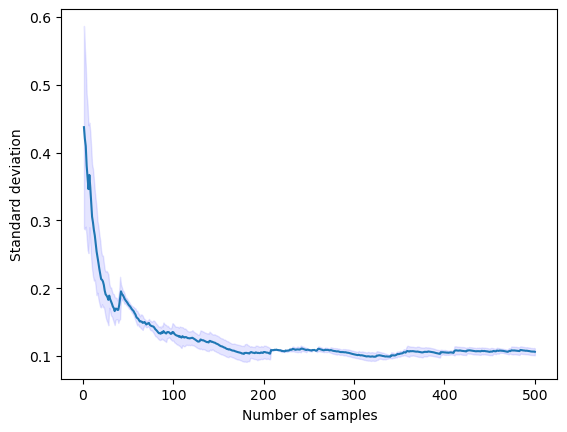

In [16]:
fig1 = plt.figure()
plt.plot(np.arange(1,501).flatten(), InfoSmooth_mean5.flatten(), label='test')
plt.fill_between(np.arange(1,501).flatten(), InfoSmooth_mean5.flatten() - InfoSmooth_std5.flatten(), 
                 InfoSmooth_mean5.flatten() + InfoSmooth_std5.flatten(), alpha=0.1, color='blue')

plt.xlabel('Number of samples')
plt.ylabel('Standard deviation')
plt.show()

In [17]:
import pickle
# Saving the objects:
with open('AL_Informativeness_iGS_20230521.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([R2Smooth_std5, accuracySmooth5, InfoSmooth_std5, InfoSmooth_mean5,\
        MSEsmooth_std5,MSEsmooth5,MAEsmooth_std5, MAEsmooth5,\
        R2_train_std5, R2_train_mean5, R2_train_stdS5, R2_train_meanS5, SelectData], f)

In [35]:
import pickle
# Getting back the objects:
with open('WD_SpinodaldendriticWavy_2pt_20230514.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    R2Smooth_std1, accuracySmooth1, InfoSmooth_std, InfoSmooth_mean,\
                 MSEsmooth_std1,MSEsmooth1,MAEsmooth_std1, MAEsmooth1,\
                 R2_train_std1, R2_train_mean1, R2_train_stdS1, R2_train_meanS1, SelectData = pickle.load(f)

- Summary

In [18]:
import pickle
# Getting back the objects:
with open('AL_Informativeness_RS_20230521.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    R2Smooth_std1, accuracySmooth1, InfoSmooth_std1, InfoSmooth_mean1,\
                 MSEsmooth_std1,MSEsmooth1,MAEsmooth_std1, MAEsmooth1,\
                 R2_train_std1, R2_train_mean1, R2_train_stdS1, R2_train_meanS1, SelectData1 = pickle.load(f)
    
with open('AL_Informativeness_US_20230521.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    R2Smooth_std2, accuracySmooth2, InfoSmooth_std2, InfoSmooth_mean2,\
        MSEsmooth_std2,MSEsmooth2,MAEsmooth_std2, MAEsmooth2,\
        R2_train_std2, R2_train_mean2, R2_train_stdS2, R2_train_meanS2, SelectData = pickle.load(f)

with open('AL_Informativeness_GSx_20230521.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    R2Smooth_std3, accuracySmooth3, InfoSmooth_std3, InfoSmooth_mean3,\
                 MSEsmooth_std3,MSEsmooth3,MAEsmooth_std3, MAEsmooth3,\
                 R2_train_std3, R2_train_mean3, R2_train_stdS3, R2_train_meanS3, SelectData = pickle.load(f)
    
with open('AL_Informativeness_GSy_20230521.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    R2Smooth_std4, accuracySmooth4, InfoSmooth_std4, InfoSmooth_mean4,\
        MSEsmooth_std4, MSEsmooth4, MAEsmooth_std4, MAEsmooth4,\
        R2_train_std4, R2_train_mean4, R2_train_stdS4, R2_train_meanS4, SelectData= pickle.load(f)
    
with open('AL_Informativeness_iGS_20230521.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    R2Smooth_std5, accuracySmooth5, InfoSmooth_std5, InfoSmooth_mean5,\
        MSEsmooth_std5,MSEsmooth5,MAEsmooth_std5, MAEsmooth5,\
        R2_train_std5, R2_train_mean5, R2_train_stdS5, R2_train_meanS5, SelectData = pickle.load(f)

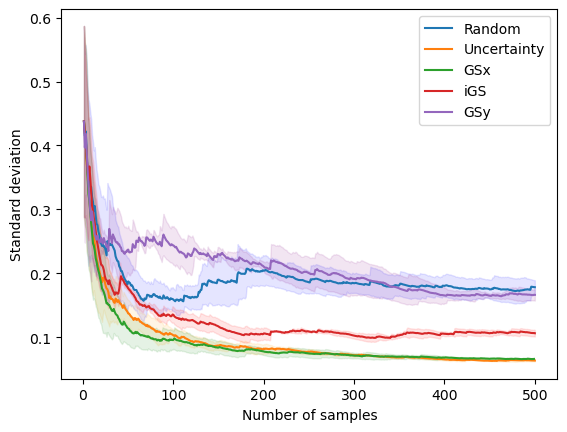

In [21]:
fig1 = plt.figure()

plt.plot(np.arange(1,501).flatten(), InfoSmooth_mean1.flatten(), label='Random')
plt.fill_between(np.arange(1,501).flatten(), InfoSmooth_mean1.flatten() - InfoSmooth_std1.flatten(), 
                 InfoSmooth_mean1.flatten() + InfoSmooth_std1.flatten(), alpha=0.1, color='blue')

plt.plot(np.arange(1,501).flatten(), InfoSmooth_mean2.flatten(), label='Uncertainty')
plt.fill_between(np.arange(1,501).flatten(), InfoSmooth_mean2.flatten() - InfoSmooth_std2.flatten(), 
                 InfoSmooth_mean2.flatten() + InfoSmooth_std2.flatten(), alpha=0.1, color='orange')

plt.plot(np.arange(1,500).flatten(), InfoSmooth_mean3.flatten(), label='GSx')
plt.fill_between(np.arange(1,500).flatten(), InfoSmooth_mean3.flatten() - InfoSmooth_std3.flatten(), 
                 InfoSmooth_mean3.flatten() + InfoSmooth_std3.flatten(), alpha=0.1,color='g')

plt.plot(np.arange(1,501).flatten(), InfoSmooth_mean5.flatten(), label='iGS')
plt.fill_between(np.arange(1,501).flatten(), InfoSmooth_mean5.flatten() - InfoSmooth_std5.flatten(), 
                 InfoSmooth_mean5.flatten() + InfoSmooth_std5.flatten(), alpha=0.1, color='r')

plt.plot(np.arange(1,501).flatten(), InfoSmooth_mean4.flatten(), label='GSy')
plt.fill_between(np.arange(1,501).flatten(), InfoSmooth_mean4.flatten() - InfoSmooth_std4.flatten(), 
                 InfoSmooth_mean4.flatten() + InfoSmooth_std4.flatten(), alpha=0.1,color='purple' )




plt.xlabel('Number of samples')
plt.ylabel('Standard deviation')
plt.legend()
plt.show()